# Group Project Report: Pulsar Star Classification
**Authors:** Sneh Agarwal, Janahan Dhushenthen, Blake Kezar, and Max Mai <br>
**Date:** December 8, 2021

## 1. Introduction

### Background
Pulsars are rapidly rotating, highly magnetized neutron stars that produce radio emissions detectable on earth. They have attracted scientific interest as being probes of space time, interstellar medium, and states of matter.

Each pulsar produces a unique emission with every rotation. Owing to this, a ‘candidate’ - a potential signal detection - is averaged over several rotations, determined by the length of an observation. In real practice, nearly all detections are caused by radio frequency interference (RFI) and noise, making it difficult to filter legitimate signals. Each candidate could potentially describe a real pulsar in absence of additional information.

Nowadays, machine learning tools are being used extensively to automatically label pulsar candidates, facilitating rapid analysis. Classification systems are being used widely, treating data sets as binary classification problems. In this, the minority positive class includes legitimate pulsar examples and the minority negative class comprises spurious examples.

### The Question
The predictive question that we will try to answer is: Given the mean of integrated profile and mean of the DM-SNR curve,  can we determine if a particular candidate is a pulsar or non-pulsar star?

The integrated profile is formed from pulsar signals with respect to its rotational period. Unlike a single pulse, which is highly variable, the integrated profile is consistent and stable in time. Each profile shape is unique and acts like a fingerprint for the pulsar. DM-SNR stands for dispersion measure signal-to-noise ratio. The DM-SNR curve respresents the dispersion of the pulsar signal and accounts for noise from other electromagnetic waves. We use the means of these values as predictors, because we believe that this metric will extract the most meaningful information from them. 

### The Dataset
We will be using the [HTRU2 Data Set](https://archive.ics.uci.edu/ml/datasets/HTRU2) to answer the question. This dataset contains a sample of pulsar candidates collected during the High Time Resolution Universe Survey.

The dataset contains a total of 17 898 observations, including 1 639 legitimate pulsar observations and 16 259 spurious observations. The dataset contains 8 continuous variables and a class variable, which are listed below:
1. Mean of integrated profile
2. Standard deviation of integrated profile
3. Excess kurtosis of integrated profile
4. Skewness of integrated profile
5. Mean of the DM-SNR curve
6. Standard deviation of the DM-SNR curve
7. Excess kurtosis of the DM-SNR curve
8. Skewness of the DM-SNR curve
9. Class 


## 2. Methods & Results

### Getting Started

First, we will perform some preliminary exploration of the pulsar data. We start off by importing the required libraries and setting a random seed for the analysis.

In [1]:
# Import libraries
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
# Set random seed for analysis
set.seed(3456)

### Reading in the Dataset
Here, we download and temporarily store a zip file from the UCI Machine Learning Repository, which contains the HTRU2 dataset. We then read in the contained CSV file that has the pulsar data. When reading in this file, we the assign column names described in the attribute information, and convert the outcome variable 'class' to a factor (since we will be performing binary classification). We also select the subset of columns that we need: mean of the integrated profile, mean of the DM-SNR curve, and the class.

In [3]:
# Download zip file from online archive 
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
temp <- tempfile()
download.file(url, temp)

# Read in CSV file containing pulsar data
pulsar_data <- read_csv(unz(temp, "HTRU_2.csv"), col_names = c("Profile_mean", "Profile_stdev", "Profile_skewness", "Profile_kurtosis", "DM_mean", "DM_stdev", "DM_skewness", "DM_kurtosis", "class")) %>%
               mutate(class = as_factor(class)) %>%
               select(Profile_mean, DM_mean, class)
unlink(temp)

head(pulsar_data)

Parsed with column specification:
cols(
  Profile_mean = col_double(),
  Profile_stdev = col_double(),
  Profile_skewness = col_double(),
  Profile_kurtosis = col_double(),
  DM_mean = col_double(),
  DM_stdev = col_double(),
  DM_skewness = col_double(),
  DM_kurtosis = col_double(),
  class = col_double()
)



Profile_mean,DM_mean,class
<dbl>,<dbl>,<fct>
140.56250,3.199833,0
102.50781,1.677258,0
103.01562,3.121237,0
136.75000,3.642977,0
88.72656,1.178930,0
93.57031,1.636288,0


### Summarizing the Data
Next, we split the dataset into 75% training data and 25% testing data, using stratified sampling with respect to the outcome variable 'class'. There is a tradeoff between using more training data for a more accurate model and more testing data for more accurate evaluation. The 75/25 split that we use is supported by empirical research, where any split of data between the ranges of 70/30 and 80/20 typically result in the most accurate model.

In [4]:
# Split pulsar dataset into training and testing data
pulsar_split <- initial_split(pulsar_data, prop = 0.75, strata = class)
pulsar_test <- testing(pulsar_split)
pulsar_train <- training(pulsar_split)   
head(pulsar_train)

Profile_mean,DM_mean,class
<dbl>,<dbl>,<fct>
140.5625,3.199833,0
102.5078,1.677258,0
103.0156,3.121237,0
136.7500,3.642977,0
130.3828,1.220736,0
107.2578,4.079431,0


The training data is then summarized into tables. For our first table, we find the number of observations in each class. The dataset should have the same proportion of each class, so that the K-nearest neighbour algorithm isn't more likely to choose one class over the other. Based on our table, we can see that there are a lot more non-pulsar observations than pulsar observations. This means that we will have to perform upsampling later on.

In [5]:
# Report the number of observations in each class
n_by_class <- pulsar_train %>% 
              group_by(class) %>%
              summarize(n = n())
n_by_class

`summarise()` ungrouping output (override with `.groups` argument)



class,n
<fct>,<int>
0,12188
1,1236


For our second table, we calculate the means of the predictor variables. Based on our table, we can see the mean of the integrated profile is 111.1 and the mean of the DM-SNR curve is 12.7. This shows us that we need to standardize the data, so that the K-nearest neighbours algorithm will get equal effects from each variable. 


In [6]:
# Report the means of the predictor variables
mean_by_predictor <- pulsar_train %>% 
                     summarize(across(Profile_mean:DM_mean, mean)) %>%
                     pivot_longer(cols = Profile_mean:DM_mean, names_to = "predictor", values_to = "mean")
mean_by_predictor

predictor,mean
<chr>,<dbl>
Profile_mean,111.17591
DM_mean,12.76068


For our last table, we identify the number of rows that have missing data. This will help us identify the number of valid observations that we can use for our analysis. Based on our table, we have no missing data, so we can use all of the observations.

In [7]:
# Report how many rows have missing data
num_NAs <- pulsar_train %>% 
           filter(is.na(pulsar_train)) %>% 
           summarize(NAs = n())
num_NAs

NAs
<int>
0


### Visualizing the Data
Next, we create a visualization that compares the distributions of each of the predictor variables. To do this, we use the training data create density plots of the mean of the integrated profile and mean of the DM-SNR curve, which are separated by class. From the visualization, we can see that in each plot, the classes form two distinct distributions, which will allow for meaningful classification. We also see that the variance is different between the predictors, which can be fixed through standardization.

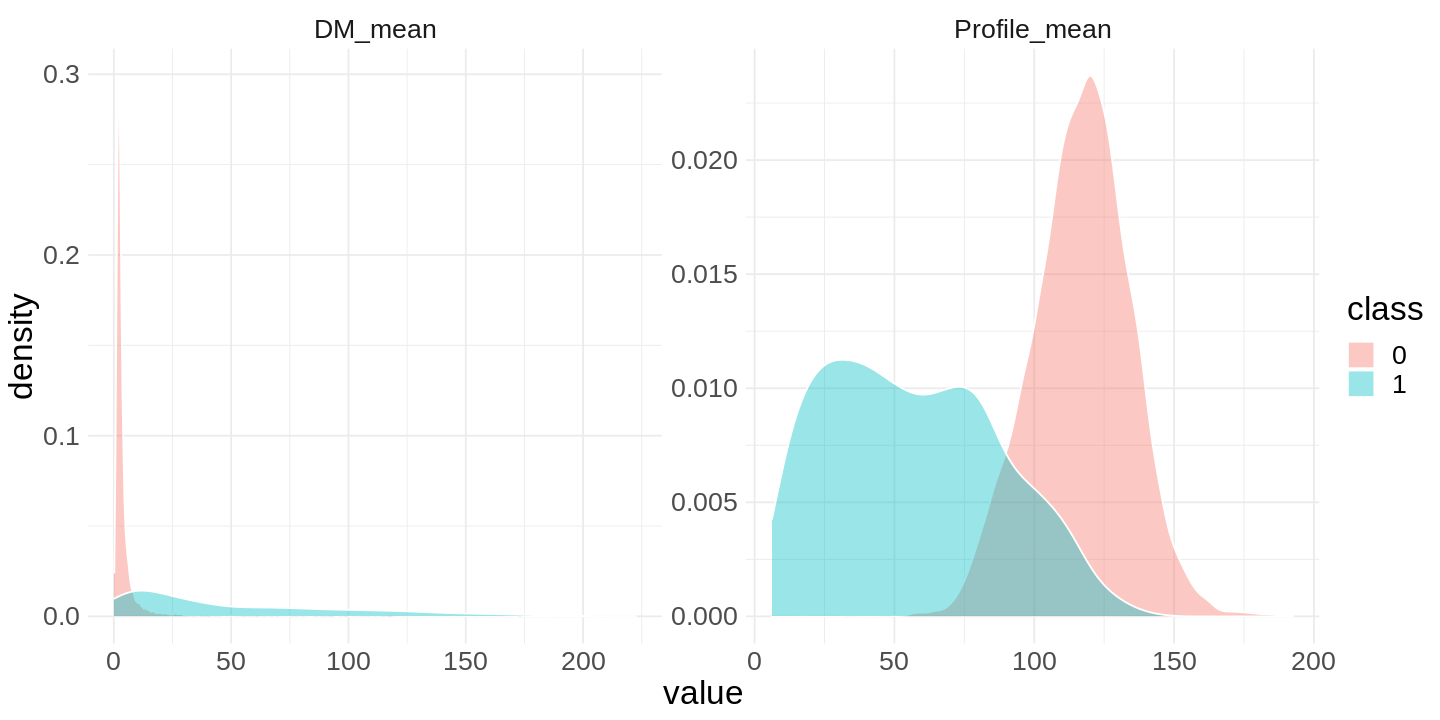

In [8]:
# Set the plot width and height
options(repr.plot.width = 12, repr.plot.height = 6) 

# Create density plot, which visualizes the distribution of each predictor variable
pulsar_train %>%
    pivot_longer(cols = -class, names_to = 'category', values_to = 'value')  %>% 
    ggplot(aes(value, fill = class)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(~ category, scales = 'free') +
        theme_minimal() +
        theme(text = element_text(size = 20))

### Parameter Value Selection
The exploratory analysis is now complete and we move on to the predictive anlaysis. First, we will use cross-validation on our training set to select the optimal value for the number of neighbours K. We will start by creating the recipe for our model, where we standardize the predictors through scaling and centering.

In [19]:
pulsar_recipe <- recipe(class ~ Profile_mean + DM_mean, data = pulsar_train) %>%
                 step_scale(all_predictors()) %>%
                 step_center(all_predictors())
pulsar_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Next, we will set the model specification, such that we are performing k-nearest neighbours classification. The "rectangular" weight function means that k-nearest neighbours will use straight-line distance and we pass in tune() for the neighbours, since are trying to find the optimal value.

In [20]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")
knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Here, we create a cross-validation dataset from the training data. We perform stratified sampling from the class and use 5-folds. We use 5 folds because... We then pass the recipe, model specification and cross-validation data into a workflow. 

In [21]:
pulsar_vfold <- vfold_cv(pulsar_train, v = 5, strata = class)

knn_results <- workflow() %>%
               add_recipe(pulsar_recipe) %>%
               add_model(knn_spec) %>%
               tune_grid(resamples = pulsar_vfold, grid = 10) %>%
               collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9543355,5,0.001596135,Model1
1,roc_auc,binary,0.8651012,5,0.006954577,Model1
3,accuracy,binary,0.9669248,5,0.001684131,Model2
3,roc_auc,binary,0.9153073,5,0.005717206,Model2
5,accuracy,binary,0.9700536,5,0.001725522,Model3
5,roc_auc,binary,0.9256495,5,0.005495199,Model3
7,accuracy,binary,0.9702024,5,0.001840572,Model4
7,roc_auc,binary,0.9319359,5,0.004658729,Model4
8,accuracy,binary,0.9702024,5,0.001840572,Model5


We can then pull the accuracies

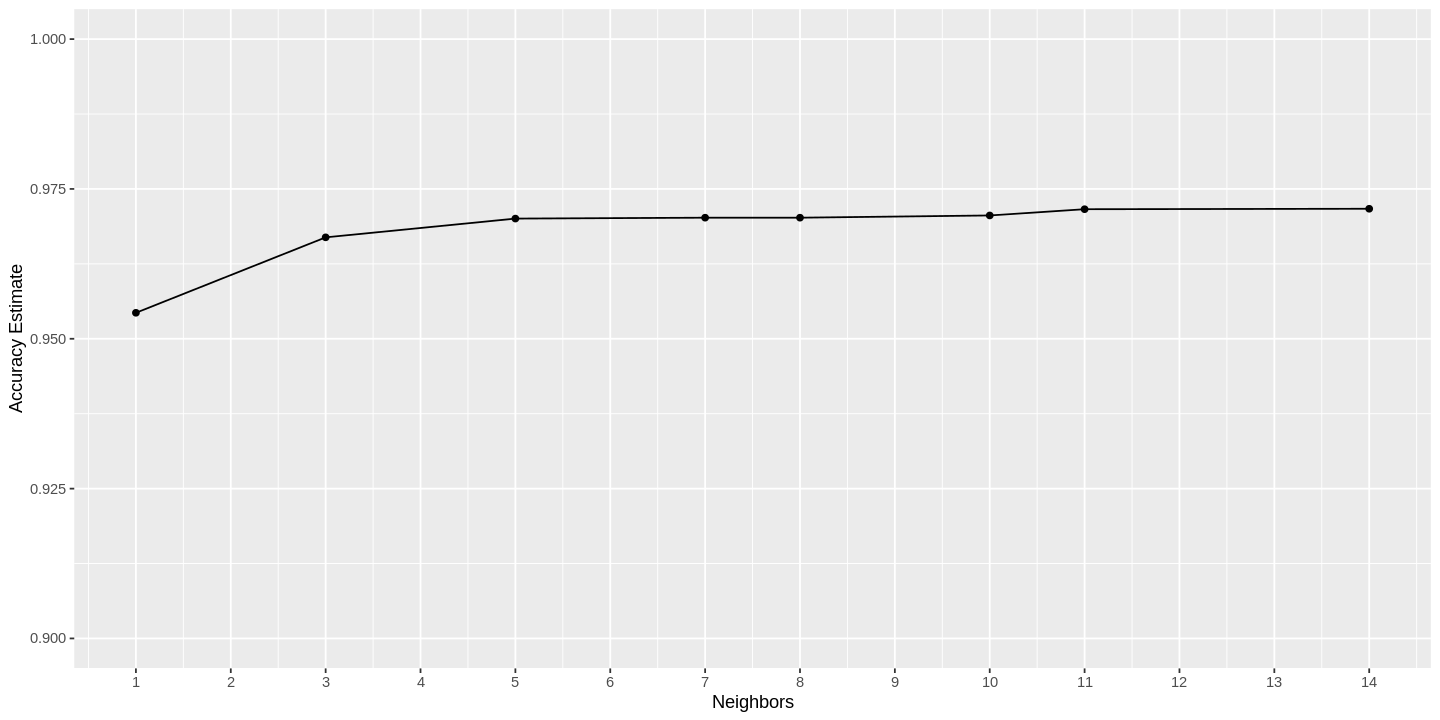

In [26]:
accuracies <- knn_results %>% 
              filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = "Neighbors", y = "Accuracy Estimate") +
                  scale_x_continuous(breaks = seq(0, 14, by = 1)) +
                  scale_y_continuous(limits = c(0.90, 1.0))
cross_val_plot

Based on the plot above, we choose K = 3 to be optimal, which resulted in an estimated accuracy of approximately 97%. After this point, the estimated accuracy only increased marginally. So, we redo the model specification (and therefore workflow) using K = 3. This is then used to make predictions on the testing dataset.

In [29]:
pulsar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
               set_engine("kknn") %>%
               set_mode("classification")

pulsar_fit <- workflow() %>%
              add_recipe(pulsar_recipe) %>%
              add_model(pulsar_spec) %>%
              fit(data = pulsar_train)

pulsar_predictions <- predict(pulsar_fit, pulsar_test) %>%
                      bind_cols(pulsar_test)
head(pulsar_predictions)

.pred_class,Profile_mean,DM_mean,class
<fct>,<dbl>,<dbl>,<fct>
0,88.72656,1.1789298,0
0,93.57031,1.6362876,0
0,119.48438,0.9991639,0
0,107.25000,2.3319398,0
0,134.96094,10.6964883,0
0,105.44531,3.5518395,0


We can get the metrics about the predictions. We see that the classifier was 94.3% accurate on the testing data.

In [32]:
pulsar_metrics <- pulsar_predictions %>%
                  metrics(truth = class, estimate = .pred_class)             
pulsar_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9436746
kap,binary,0.6160486


We can also look at the confusion matrix, which shows.

In [30]:
pulsar_conf_mat <- pulsar_predictions %>% 
                   conf_mat(truth = class, estimate = .pred_class)
pulsar_conf_mat

          Truth
Prediction    0    1
         0 4029   94
         1   42  309

Finally, we can display the results in a scatterplot.

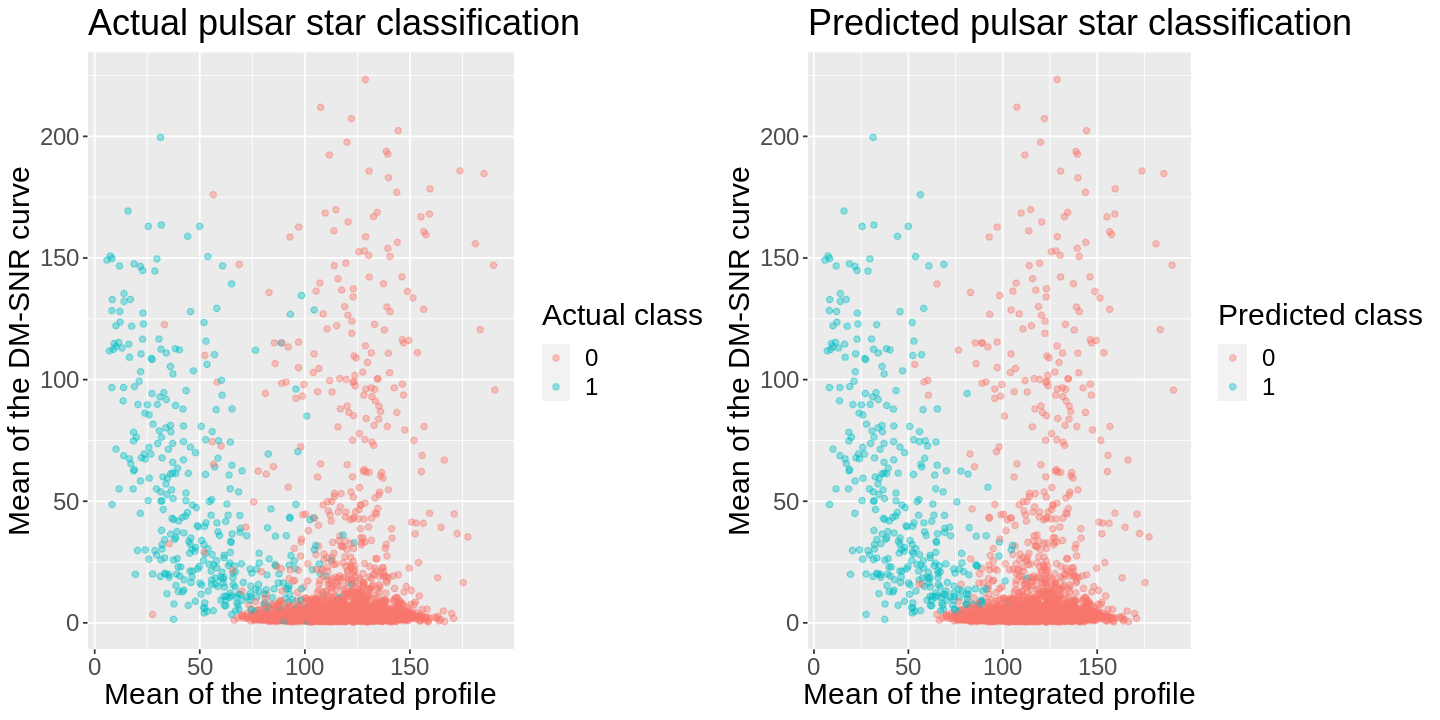

In [43]:
pulsar_plot <- pulsar_predictions %>%
               ggplot(aes(x = Profile_mean, y = DM_mean, colour = class)) + 
                   geom_point(alpha = 0.4) + 
                   xlab("Mean of the integrated profile") +
                   ylab("Mean of the DM-SNR curve") +
                   labs(colour = "Actual class") +
                   ggtitle("Actual pulsar star classification") + 
                   theme(text = element_text(size = 18))

pulsar_pred_plot <- pulsar_predictions %>%
                    ggplot(aes(x = Profile_mean, y = DM_mean, colour = .pred_class)) + 
                       geom_point(alpha = 0.4) + 
                       xlab("Mean of the integrated profile") +
                       ylab("Mean of the DM-SNR curve") +
                       labs(colour = "Predicted class") +
                       ggtitle("Predicted pulsar star classification") + 
                       theme(text = element_text(size = 18))

library(cowplot)
plot_grid(pulsar_plot, pulsar_pred_plot)

## 3. Discussion 

### Summary of Findings
Accuracy of the model, confusion matrix (false positives/negatives, etc.), number of neighbors, some info about predictors

### Findings vs Expectations
Using the model we build to tell if a new found star is a Pulsar Star or not.

### Potential Impacts
With the pulsar stars classified, scientists can study extreme states of matter, search for planets beyond Earth's solar system, and measure cosmic distances. Pulsars could also help scientists find gravitational waves, which could point the way to energetic cosmic events like collisions between supermassive black holes.

### Potential Future Questions
This can lead to a number of questions, such as:
* What things are inside a pulsar star?
* How big and wide is a pulsar star?
* How do magnetic fields and extreme gravity affect the radiation?

## 4. References
[1] R. J. Lyon et al., 'Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach', Monthly Notices of the Royal Astronomical Society 459 (1), 1104-1123, DOI: 10.1093/mnras/stw656 <br>
[2] Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.